In [1]:
import os
import numpy as np
import pandas as pd 
import pickle
import matplotlib.pyplot as plt
import copy 
from ucimlrepo import fetch_ucirepo 

import torch
import torch.nn as nn
import torch.optim as optim
from hyperopt import fmin, tpe, hp, Trials
from hyperopt.pyll.base import scope

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, matthews_corrcoef
from sklearn.model_selection import train_test_split


from ltn_imp.automation.knowledge_base import KnowledgeBase

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Prepare Dataset

In [3]:
data = pd.read_csv("datasets/pima_indians_imputed.csv", index_col=0).astype(np.float32)
data["DiabetesPedigreeFunction"] =  data["DiabetesPedigreeFunction"] * 100
data["Pregnancies"] = data["Pregnancies"] * 10

In [ ]:
data.columns

In [ ]:
print(data.isna().sum())
data = data.dropna()

In [6]:
def prepare_datasets(data, random_seed=42):    
    X = data.drop("Outcome", axis=1)  # Features
    y = data["Outcome"]  # Labels

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=random_seed, stratify=y)    
    X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=random_seed, stratify=y_train)

    train_data = pd.concat([X_train, y_train], axis=1)
    test_data = pd.concat([X_test, y_test], axis=1)
    val_data = pd.concat([X_val, y_val], axis=1)
    train_data_ = pd.concat([X_train_, y_train_], axis=1)

    train_data_.to_csv("datasets/train.csv", index=False)
    test_data.to_csv("datasets/test.csv", index=False)
    val_data.to_csv("datasets/val.csv", index=False)

    return train_data, test_data

In [ ]:
prepare_datasets(data)
train = pd.read_csv("datasets/train.csv")
test = pd.read_csv("datasets/test.csv")
data = pd.concat([train, test])
print(train.shape)
print(test.shape)

In [ ]:
data.value_counts("Outcome")

# Best Hyper-Parameters

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

def find_best_models(X,y):
    param_grid = {

        'KNN': {
            'model': KNeighborsClassifier(),
            'params': {
                'n_neighbors': [3, 5, 7],
                'weights': ['uniform', 'distance'],
                'p': [1, 2]
            }
        },

        'DT': {
            'model': DecisionTreeClassifier(),
            'params': {
                'max_depth': [None, 10, 20, 30],
                'min_samples_split': [2, 5, 10],
                'criterion': ['gini', 'entropy']
            }
        },

        'RF': {
            'model': RandomForestClassifier(),
            'params': {
                'n_estimators': [50, 100, 200],
                'max_depth': [None, 10, 20],
                'min_samples_split': [2, 5],
                'criterion': ['gini', 'entropy']
            }
        },
        
        'LR': {
            'model': LogisticRegression(max_iter=1000),
            'params': {
                'C': [0.1, 1, 10],
                'solver': ['lbfgs', 'liblinear']
            }
        }
    }

    best_models = {}
    for name, model_info in param_grid.items():
        grid_search = GridSearchCV(model_info['model'], model_info['params'], cv=5, n_jobs=-1)
        grid_search.fit(X, y)
        best_models[name] = grid_search.best_estimator_

    models = []
    for name, model in best_models.items():
        if name == 'LR':
            models.append(LogisticRegression(**model.get_params()))
        elif name == 'KNN':
            models.append(KNeighborsClassifier(**model.get_params()))
        elif name == 'DT':
            models.append(DecisionTreeClassifier(**model.get_params()))
        elif name == 'RF':
            models.append(RandomForestClassifier(**model.get_params()))

    return models

In [10]:
class MLP(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, dropout_prob=0.5):
        super(MLP, self).__init__()
        layers = []
        in_size = input_size
        
        # Build layers with dropout
        for out_size in hidden_layers:
            layers.append(nn.Linear(in_size, out_size))
            layers.append(nn.LeakyReLU())  # LeakyReLU activation
            layers.append(nn.Dropout(p=dropout_prob))  # Dropout layer
            layers.append(nn.BatchNorm1d(out_size))
            in_size = out_size
        
        # Output layer
        layers.append(nn.Linear(in_size, output_size))
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [ ]:
kb = KnowledgeBase("config.yaml")

def objective(params):
    learning_rate = params['learning_rate']
    weight_decay = params['weight_decay']
    hidden_layer_sizes = params['hidden_layer_sizes']
    num_epochs = params['num_epochs']
    dropout_prob = params['dropout_prob'] 

    model = MLP(input_size=8, output_size=1, hidden_layers=hidden_layer_sizes, dropout_prob=dropout_prob)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    model.train()
    for epoch in range(num_epochs): 
        for batch_X, batch_y in kb.loaders[0]:  
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

    # Evaluate the model
    model.eval()
    total_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_X, batch_y in kb.test_loaders[0]:  
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == batch_y).sum().item()
    
    return total_loss

# Define the hyperparameter search space
space = {
    'learning_rate': hp.loguniform('learning_rate', -6, -1),  # 1e-5 to 1
    'weight_decay': hp.loguniform('weight_decay', -5, -1),   # 1e-6 to 1e-2

    'hidden_layer_sizes': hp.choice('hidden_layer_sizes', [
        [512, 256, 128, 64, 32],  # Architecture with 5 layers
        [256, 128, 64, 32],       # Architecture with 4 layers

        [512, 256, 128],          # Architecture with 3 layers
        [256, 128, 64],           # Architecture with 3 layers

        [512, 256],               # Architecture with 2 layers
        [256, 128],               # Architecture with 2 layers

        [512],                    # Architecture with 1 layer
    ]),

    'num_epochs': scope.int(hp.quniform('num_epochs', 5, 50, 1)),  # Epochs range from 5 to 200
    'dropout_prob': hp.uniform('dropout_prob', 0.1, 0.5)  # Dropout probability between 0.1 and 0.5
}

trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,  # Use the TPE algorithm
    max_evals=1,  
    trials=trials
)

print("Best hyperparameters:", best)

# Train and Evaluate Models

In [12]:
models = find_best_models(train.drop("Outcome", axis=1), train["Outcome"])
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(256, 128, 64), max_iter=1000, random_state=42)
models.append(mlp)

In [13]:
models.append(kb.predicates["Diabetic"])

In [14]:
model_names = [type(model).__name__ for model in models]
model_names

['KNeighborsClassifier',
 'DecisionTreeClassifier',
 'RandomForestClassifier',
 'LogisticRegression',
 'MLPClassifier',
 'LogicTensorNetwork']

In [15]:
columns = train.columns[:-1]

In [16]:
metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "Balanced Accuracy", "MCC"]

## This section includes all methods needed to train and evalute all models

In [17]:
device = torch.device("cpu")

def predict(model, x):

    if hasattr(model, 'predict'):
        if isinstance(x, torch.Tensor):
            x = x.cpu().numpy()
        preds = model.predict(x)
        return torch.tensor(preds, dtype=torch.float32)
    
    model.eval() 

    if not isinstance(x, torch.Tensor):
        x = torch.tensor(x, dtype=torch.float32)
    elif x.dtype != torch.float32:
        x = x.float()

    with torch.no_grad():  
        probs = model(x)
        preds = (probs > 0.5).float()

    return preds

def evaluate_model(loader, model, device):
    all_true_labels = []
    all_predicted_labels = []
    
    with torch.no_grad():  # Disable gradient computation
        for data, labels in loader:
            # Ensure data and labels are the correct dtype
            if not isinstance(data, torch.Tensor):
                data = torch.tensor(data, dtype=torch.float32)
            elif data.dtype != torch.float32:
                data = data.float()
            
            if not isinstance(labels, torch.Tensor):
                labels = torch.tensor(labels, dtype=torch.float32)
            elif labels.dtype != torch.float32:
                labels = labels.float()
            
            # Get predictions
            preds = predict(model, data)

            # Squeeze predictions and labels to remove dimensions of size 1
            predicted_labels = preds.squeeze()
            true_labels = labels.squeeze()

            # Ensure the shapes match before comparison
            if predicted_labels.shape != true_labels.shape:
                true_labels = true_labels.view_as(predicted_labels)
            
            # Collect all predictions and true labels for MCC
            all_true_labels.extend(true_labels.cpu().numpy())
            all_predicted_labels.extend(predicted_labels.cpu().numpy())

    true_labels = np.array(all_true_labels)
    predicted_labels = np.array(all_predicted_labels)
    
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, zero_division=0)  # zero_division=0 handles the division by zero case
    recall = recall_score(true_labels, predicted_labels, zero_division=0)
    f1 = f1_score(true_labels, predicted_labels, zero_division=0)
    balanced_accuracy = balanced_accuracy_score(true_labels, predicted_labels)
    mcc = matthews_corrcoef(true_labels, predicted_labels)

    try:
        model.train()
    except:
        ""

    return accuracy, precision, recall, f1, balanced_accuracy, mcc

def evaluate_sklearn_model(dataset, model):
    # Assuming the last column is the label
    data = dataset.iloc[:, :-1]  # All columns except the last one are features
    true_labels = dataset.iloc[:, -1]  # The last column is the label

    # Predict using the sklearn model
    predicted_labels = model.predict(data)

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, zero_division=0)  
    recall = recall_score(true_labels, predicted_labels, zero_division=0)
    f1 = f1_score(true_labels, predicted_labels, zero_division=0)
    balanced_accuracy = balanced_accuracy_score(true_labels, predicted_labels)
    mcc = matthews_corrcoef(true_labels, predicted_labels)

    return accuracy, precision, recall, f1, balanced_accuracy, mcc

# Rule 1: (BMI > 29 and Glucose > 125) -> Diabetic (1)
def rule_1(data_df):
    condition = (data_df['BMI'] > 29) & (data_df['Glucose'] > 125)
    outcome = pd.Series(np.nan, index=data_df.index)
    outcome[condition] = 1  # Diabetic
    return outcome

# Rule 2: (BMI < 26 and Glucose < 101) -> Not Diabetic (0)
def rule_2(data_df):
    condition = (data_df['BMI'] < 26) & (data_df['Glucose'] < 101)
    outcome = pd.Series(np.nan, index=data_df.index)
    outcome[condition] = 0  # Not Diabetic
    return outcome

def rule_adherence(model, test_set):

    if isinstance(test_set, pd.DataFrame):
        X = test_set.iloc[:, :-1].values
    elif isinstance(test_set, np.ndarray):
        X = test_set[:, :-1]
    elif isinstance(test_set, torch.Tensor):
        X = test_set[:, :-1].numpy()

    data_df = pd.DataFrame(X, columns=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
                                       'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'])
    
    preds = predict(model, X).numpy()

    expected_outcome_rule_1 = rule_1(data_df)
    rule_1_indices = expected_outcome_rule_1[~expected_outcome_rule_1.isna()].index

    adherence_rule_1 = 0
    if len(rule_1_indices) > 0:
        relevant_preds_rule_1 = preds[rule_1_indices]
        adherence_rule_1 = np.sum(relevant_preds_rule_1 == 1)
    
    total_rule_1 = len(rule_1_indices)
    adherence_percentage_rule_1 = (adherence_rule_1 / total_rule_1 * 100) if total_rule_1 > 0 else np.nan

    expected_outcome_rule_2 = rule_2(data_df)
    rule_2_indices = expected_outcome_rule_2[~expected_outcome_rule_2.isna()].index

    adherence_rule_2 = 0
    if len(rule_2_indices) > 0:
        relevant_preds_rule_2 = preds[rule_2_indices]
        adherence_rule_2 = np.sum(relevant_preds_rule_2 == 0)
    
    total_rule_2 = len(rule_2_indices)
    adherence_percentage_rule_2 = (adherence_rule_2 / total_rule_2 * 100) if total_rule_2 > 0 else np.nan

    adherence_percentages = {
        'Rule 1': adherence_percentage_rule_1,
        'Rule 2': adherence_percentage_rule_2
    }
    
    return adherence_percentages


In [18]:
import torch.nn as nn

def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

    linear_layers = [module for module in model.modules() if isinstance(module, nn.Linear)]

    for layer in linear_layers[-2:]:
        for param in layer.parameters():
            param.requires_grad = True

def train_model(model, kb):

    criteria = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

    patience = 5
    min_delta = 0.0
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for _ in range(50):
        model.train()
        total_loss = 0.0
        num_batches = 0
        
        # Training loop
        for data, labels in kb.loaders[0]:
            optimizer.zero_grad()
            predictions = model(data)
            loss = criteria(predictions, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            num_batches += 1

        model.eval()
        total_val_loss = 0.0
        num_val_batches = 0

        for data, labels in kb.val_loaders[0]:
            with torch.no_grad():
                predictions = model(data)
                val_loss = criteria(predictions, labels)
                total_val_loss += val_loss.item()
                num_val_batches += 1

        avg_val_loss = total_val_loss / num_val_batches

        # Early stopping logic
        if avg_val_loss + min_delta < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            break

        model.train()

In [19]:
kb = KnowledgeBase("config.yaml")

Using device: cpu


In [20]:
import copy 

metrics_df = pd.DataFrame([ [ [] for _ in metrics ] for _ in model_names ] , columns=metrics, index=[model_names])
adherence_df = pd.DataFrame([ [ [] for _ in range(1, len(kb.rules) - 1) ] for _ in model_names ] , columns=[f"Rule {i}" for i in range(1, len(kb.rules) - 1)], index=[model_names])
seeds = [seed for seed in range(0, 50)]

data = pd.read_csv("datasets/pima_indians_imputed.csv", index_col=0).astype(np.float32)
data["DiabetesPedigreeFunction"] =  data["DiabetesPedigreeFunction"] * 100
data["Pregnancies"] = data["Pregnancies"] * 10

for seed in seeds:
    train, test = prepare_datasets(data, seed)
    for model in models:
        model_name = type(model).__name__
        
        if not hasattr(model, "fit"):
            
            kb = KnowledgeBase("config.yaml")            
            model = kb.predicates["Diabetic"]
            train_model(model, kb)
            freeze_model(model.model)
            kb.optimize(num_epochs=200, lr=0.000001, early_stopping=True, verbose=False)
            
            model = copy.deepcopy( kb.predicates["Diabetic"] ) 
            metrics_values = evaluate_model(kb.test_loaders[0], model, kb.device)
            adherence_values = rule_adherence(model, test)

            for metric, value in zip(metrics, metrics_values):
                metrics_df.loc[model_name][metric][0].append(value)

            for rule, adherence in adherence_values.items():
                adherence_df.loc[model_name][rule][0].append(adherence)
                            
        else:
            model.fit(train.drop("Outcome", axis=1), train["Outcome"])
            metrics_values = evaluate_sklearn_model(test, model)
            adherence_values = rule_adherence(model, test)

            for metric, value in zip(metrics, metrics_values):
                metrics_df.loc[model_name][metric][0].append(value)

            for rule, adherence in adherence_values.items():
                adherence_df.loc[model_name][rule][0].append(adherence)

Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu


# Performance Evaluation

## Model Evaluation with 50 Random States

This section evaluates all models across 50 different random states in performance metrics. The following steps are performed:

 ### 1. Box Plot Visualization:  
   Box plots are generated for the evaluation metrics, allowing a clear visual comparison of model performance.
   
   

 ### 2. T-Test Comparisons:  
   Two sets of T-tests are conducted:
   
   - **Best Model Significance Test**:  
     For each evaluation metric, the T-test checks if the best-performing model is significantly better than the others.
   
   - **Comparison with Our Model**:  
     For cases where our model is not the best, it is compared against each of the other models for each metric.


In [21]:
def plot_metrics(metrics_df, metrics_to_plot):
    plt.figure(figsize=(18, len(metrics_to_plot) * 4))

    for i, metric in enumerate(metrics_to_plot, 1):
        plt.subplot(len(metrics_to_plot), 1, i)
        data_to_plot = [metrics_df.loc[model_name, metric] for model_name in metrics_df.index]
        
        # Customize the boxplots
        boxprops = dict(linewidth=2)
        medianprops = dict(linewidth=2, color='red')
        meanprops = dict(linewidth=2, color='blue')
        whiskerprops = dict(linewidth=2)
        capprops = dict(linewidth=2)
        
        plt.boxplot(data_to_plot, labels=metrics_df.index, boxprops=boxprops, 
                    medianprops=medianprops, meanline=True, showmeans=True, 
                    meanprops=meanprops, whiskerprops=whiskerprops, 
                    capprops=capprops)
        
        plt.title(f'Boxplot of {metric} across different models')
        plt.xlabel('Model', fontweight='bold')
        plt.ylabel(metric, fontweight='bold')

    plt.tight_layout()
    plt.show()

In [22]:
import scipy.stats as stats

def compare_models(metrics_df):

    best_models = {}
    for metric in metrics_df.columns:
        try:
            mean_scores = metrics_df[metric].apply(np.mean)
            best_model = mean_scores.idxmax()  
            best_models[metric] = best_model
        except:
            print(f"Rule {metric} not available")
            continue

    results = {}
    for metric in metrics_df.columns:
        try:   
            best_model = best_models[metric]
            best_scores = metrics_df.loc[best_model, metric]
            
            results[metric] = {}
            
            for model_name in metrics_df.index:
                if model_name == best_model:
                    continue
                
                comparison_scores = metrics_df.loc[model_name, metric]
                t_stat, p_value = stats.ttest_rel(best_scores, comparison_scores)
                results[metric][model_name] = p_value 

        except:
            print(f"Rule {metric} not available")
            continue

    significance_level = 0.05
    for metric, comparisons in results.items():
        try:
            print(f"\n{metric}:")
            best_model = best_models[metric]
            for model_name, p_value in comparisons.items():
                if p_value < significance_level:
                    print(f"  {best_model} is significantly better than {model_name} (p = {p_value:.4f})")
                else:
                    print(f"  {best_model} is NOT significantly better than {model_name} (p = {p_value:.4f})")
        except:
            print(f"Rule {metric} not available")

In [23]:
def perform_t_tests(metrics_df, model_name):
    results = {}

    for metric in metrics_df.columns:

        if model_name == "LogicTensorNetwork":
            continue
        
        ski_mlp_scores = np.array(metrics_df.loc['LogicTensorNetwork', metric])
        regular_mlp_scores = np.array(metrics_df.loc[model_name, metric])
        
        t_stat, p_value = stats.ttest_rel(ski_mlp_scores, regular_mlp_scores)
        
        # Calculate the mean difference
        mean_difference = np.mean(ski_mlp_scores - regular_mlp_scores)
        
        results[metric] = {'p_value': p_value, 'mean_difference': mean_difference}

    # Significance level for the tests
    significance_level = 0.05

    for metric, result in results.items():

        if model_name == "LogicTensorNetwork":
            continue

        try:
            p_value = result['p_value']
            mean_difference = result['mean_difference']
            
            print(f"\n{metric}:")
            if p_value < significance_level:
                if mean_difference > 0:
                    print(f"  LogicTensorNetwork is significantly better than {model_name} (p = {p_value:.4f})")
                else:
                    print(f"  {model_name} is significantly better than LogicTensorNetwork (p = {p_value:.4f})")
            else:
                print(f"  There is no significant difference between LogicTensorNetwork and {model_name} (p = {p_value:.4f})")
        except:
            print(f"Rule {metric} not available")

In [24]:
metrics_df.index = model_names

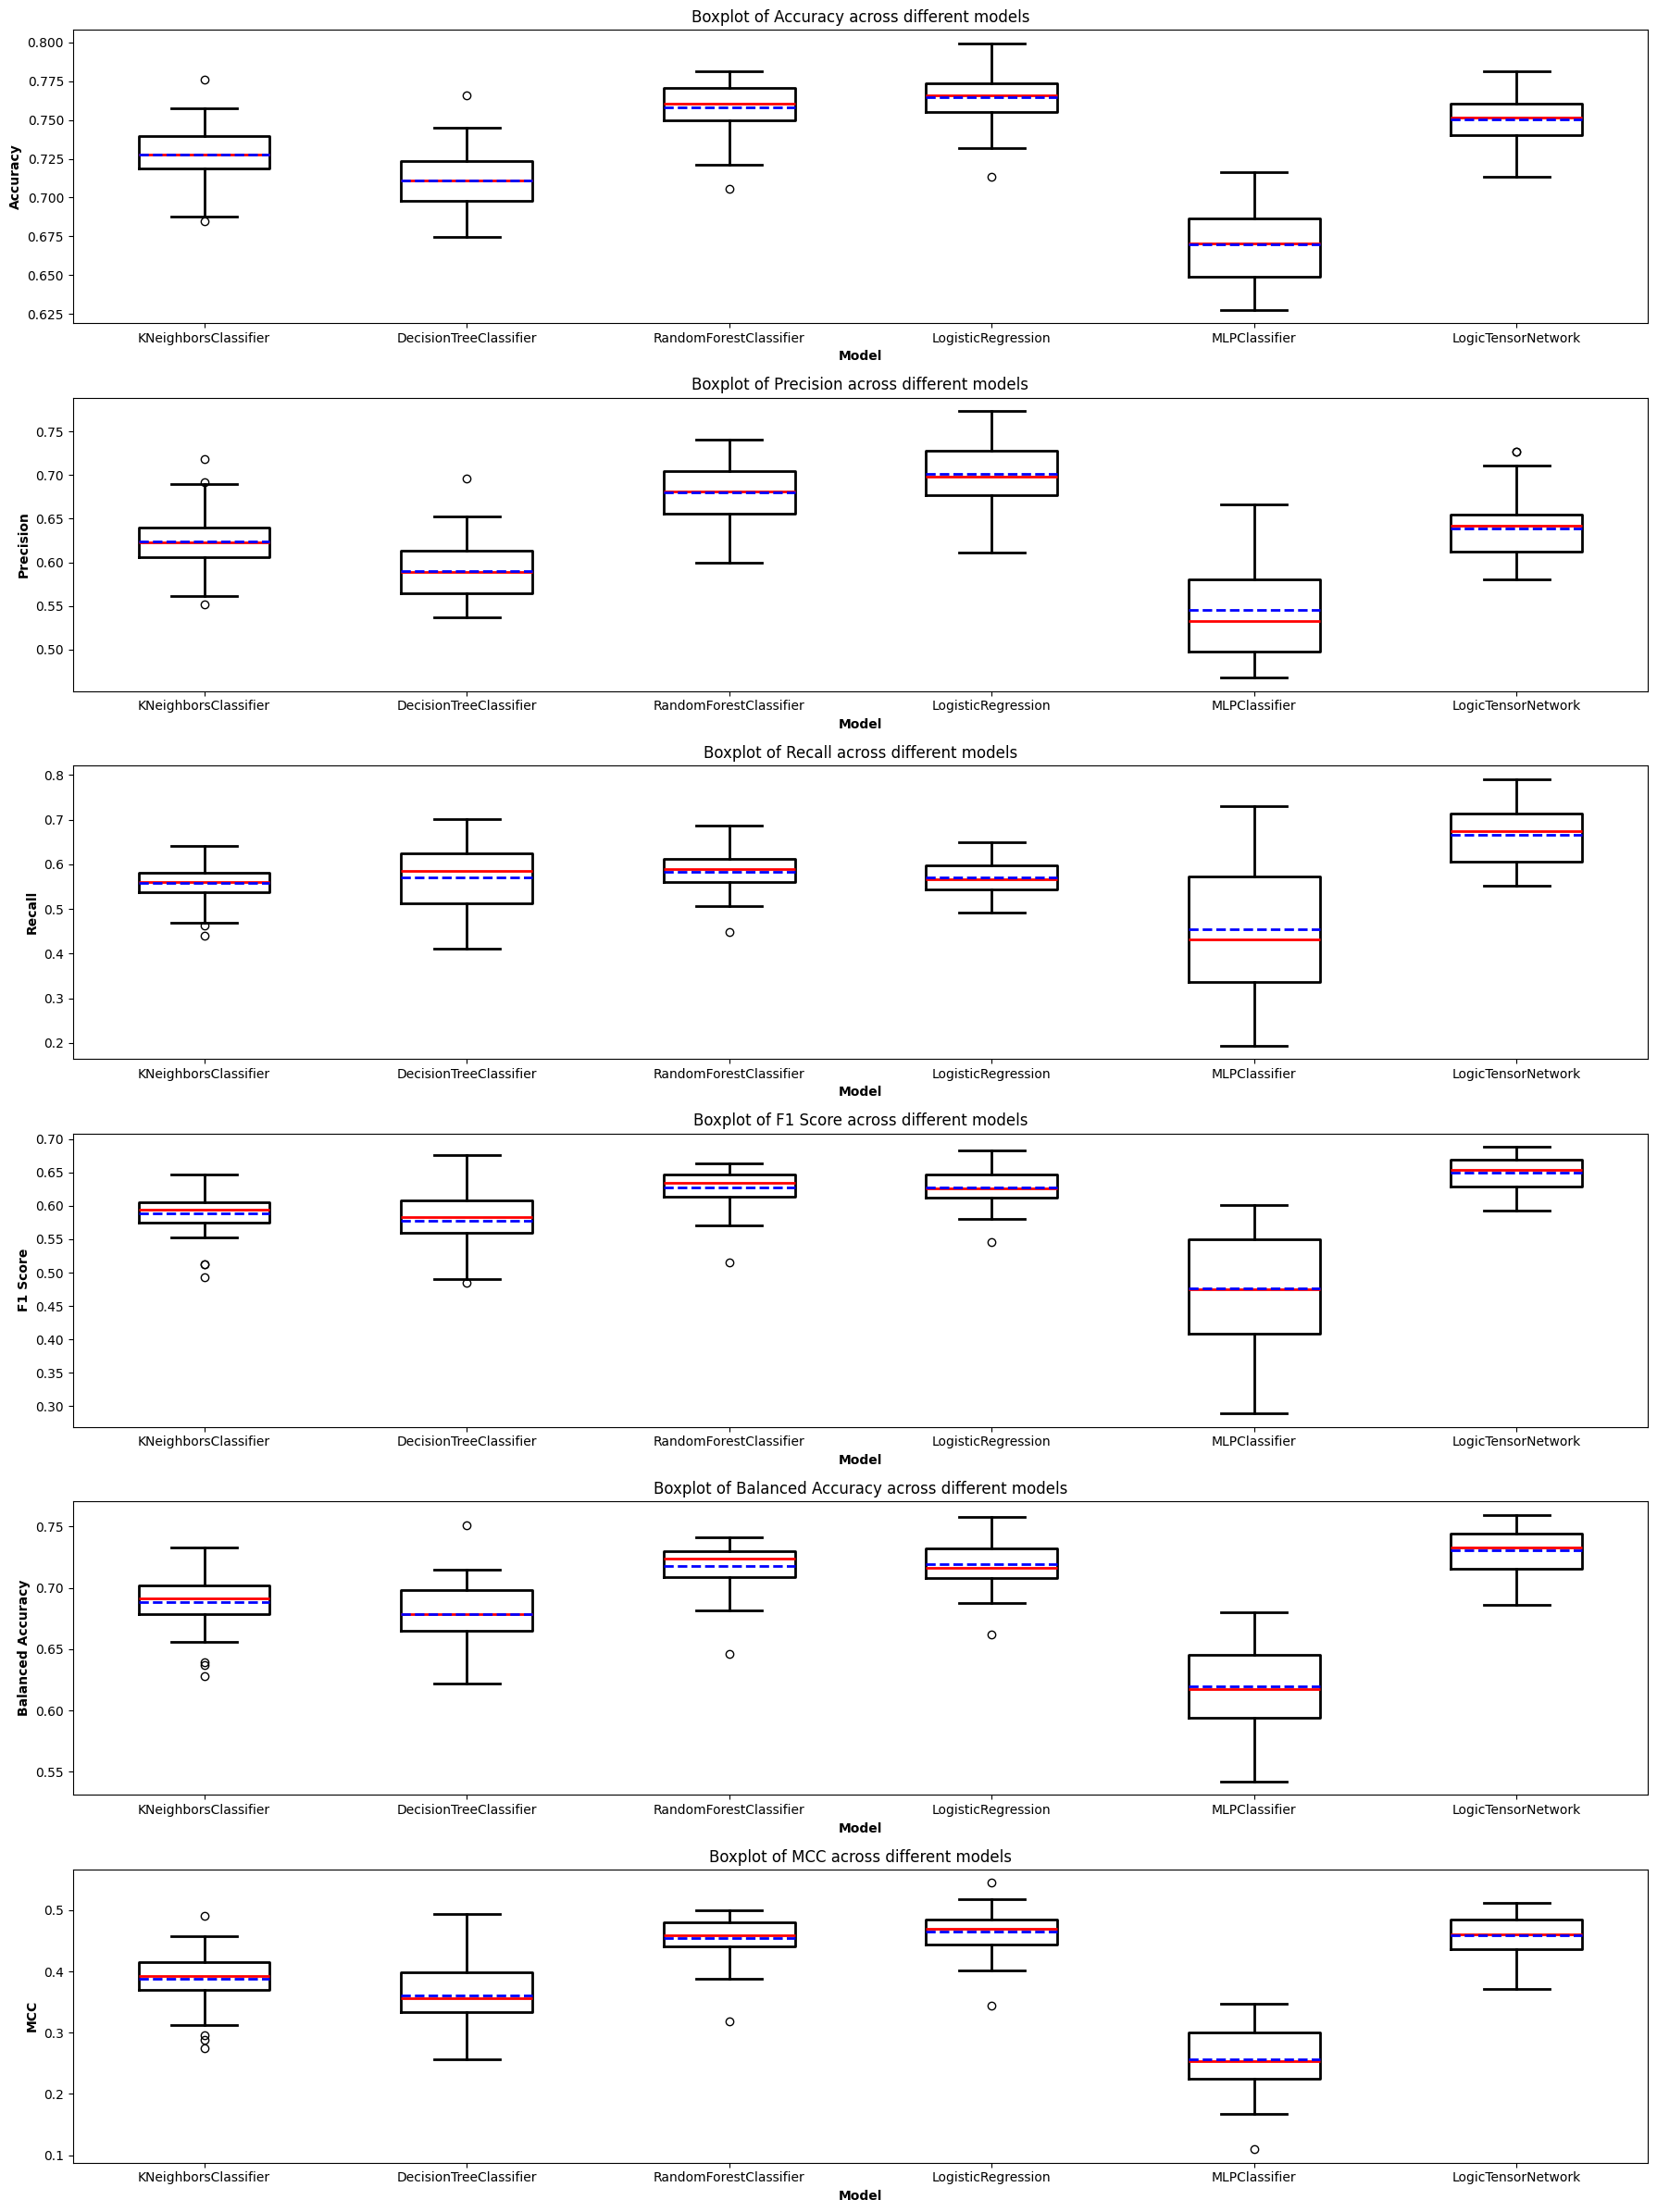

In [25]:
plot_metrics(metrics_df, metrics)

In [26]:
compare_models(metrics_df)


Accuracy:
  LogisticRegression is significantly better than KNeighborsClassifier (p = 0.0000)
  LogisticRegression is significantly better than DecisionTreeClassifier (p = 0.0000)
  LogisticRegression is significantly better than RandomForestClassifier (p = 0.0151)
  LogisticRegression is significantly better than MLPClassifier (p = 0.0000)
  LogisticRegression is significantly better than LogicTensorNetwork (p = 0.0000)

Precision:
  LogisticRegression is significantly better than KNeighborsClassifier (p = 0.0000)
  LogisticRegression is significantly better than DecisionTreeClassifier (p = 0.0000)
  LogisticRegression is significantly better than RandomForestClassifier (p = 0.0001)
  LogisticRegression is significantly better than MLPClassifier (p = 0.0000)
  LogisticRegression is significantly better than LogicTensorNetwork (p = 0.0000)

Recall:
  LogicTensorNetwork is significantly better than KNeighborsClassifier (p = 0.0000)
  LogicTensorNetwork is significantly better than Deci

In [27]:
for model in metrics_df.index:
    perform_t_tests(metrics_df, model)
    print()
    print( "-" * 100)


Accuracy:
  LogicTensorNetwork is significantly better than KNeighborsClassifier (p = 0.0000)

Precision:
  LogicTensorNetwork is significantly better than KNeighborsClassifier (p = 0.0118)

Recall:
  LogicTensorNetwork is significantly better than KNeighborsClassifier (p = 0.0000)

F1 Score:
  LogicTensorNetwork is significantly better than KNeighborsClassifier (p = 0.0000)

Balanced Accuracy:
  LogicTensorNetwork is significantly better than KNeighborsClassifier (p = 0.0000)

MCC:
  LogicTensorNetwork is significantly better than KNeighborsClassifier (p = 0.0000)

----------------------------------------------------------------------------------------------------

Accuracy:
  LogicTensorNetwork is significantly better than DecisionTreeClassifier (p = 0.0000)

Precision:
  LogicTensorNetwork is significantly better than DecisionTreeClassifier (p = 0.0000)

Recall:
  LogicTensorNetwork is significantly better than DecisionTreeClassifier (p = 0.0000)

F1 Score:
  LogicTensorNetwork is 

In [28]:
mean_df = pd.DataFrame(columns=metrics, index=model_names)

for metric in metrics_df.columns:
    mean_df[metric] = metrics_df[metric].apply(np.mean)

In [29]:
mean_df

,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy,MCC
KNeighborsClassifier,0.727760,0.623950,0.558209,0.588281,0.688424,0.388085
DecisionTreeClassifier,0.710990,0.590017,0.571791,0.578046,0.678696,0.361028
RandomForestClassifier,0.758333,0.680395,0.584179,0.627295,0.717930,0.454085
LogisticRegression,0.764427,0.701248,0.570299,0.627854,0.719389,0.464422
MLPClassifier,0.669740,0.545158,0.453881,0.476195,0.619660,0.256347
LogicTensorNetwork,0.750156,0.638816,0.665821,0.649527,0.730590,0.458532


# Logic Adherence

## Model Evaluation with 50 Random States

This section evaluates all models across 50 different random states in Logic adherence ( meaning how well aligned are the predictions with the given logic rules ). The following steps are performed:

 ### 1. Box Plot Visualization:  
   Box plots are generated for the evaluation metrics, allowing a clear visual comparison of model performance.
   
   

 ### 2. T-Test Comparisons:  
   Two sets of T-tests are conducted:
   
   - **Best Model Significance Test**:  
     For each rule, the T-test checks if the best-performing model is significantly better than the others.
   
   - **Comparison with Our Model**:  
     For cases where our model is not the best, it is compared against each of the other models for each rule.

### 3. Rules:

  Rule 1: forall person. (((person[BMI] > 29) and (person[Glucose] > 125 )) -> Diabetic(person))"
  
  Rule 2: forall person. (((person[BMI] < 26) and (person[Glucose] < 101 )) -> not Diabetic(person))"



In [30]:
adherence_df.index = model_names

In [31]:
kb = KnowledgeBase("config.yaml")
kb.optimize(num_epochs=200, lr=0.000001, early_stopping=True, verbose=False)
evaluate_model(kb.test_loaders[0], kb.predicates["Diabetic"], kb.device)

Using device: cpu


(0.7265625,
 np.float64(0.588957055214724),
 np.float64(0.7164179104477612),
 np.float64(0.6464646464646465),
 np.float64(0.7242089552238806),
 np.float64(0.4324296011256208))

In [32]:
adherence_df

,Rule 1,Rule 2
KNeighborsClassifier,"[60.16260162601627, 61.86440677966102, 64.7619...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 96...."
DecisionTreeClassifier,"[54.47154471544715, 64.40677966101694, 55.2380...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100..."
RandomForestClassifier,"[73.17073170731707, 72.03389830508475, 80.0, 7...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100..."
LogisticRegression,"[73.17073170731707, 78.8135593220339, 69.52380...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100..."
MLPClassifier,"[46.34146341463415, 62.71186440677966, 34.2857...","[86.20689655172413, 96.15384615384616, 100.0, ..."
LogicTensorNetwork,"[73.98373983739837, 83.89830508474576, 90.4761...","[100.0, 100.0, 100.0, 100.0, 95.45454545454545..."


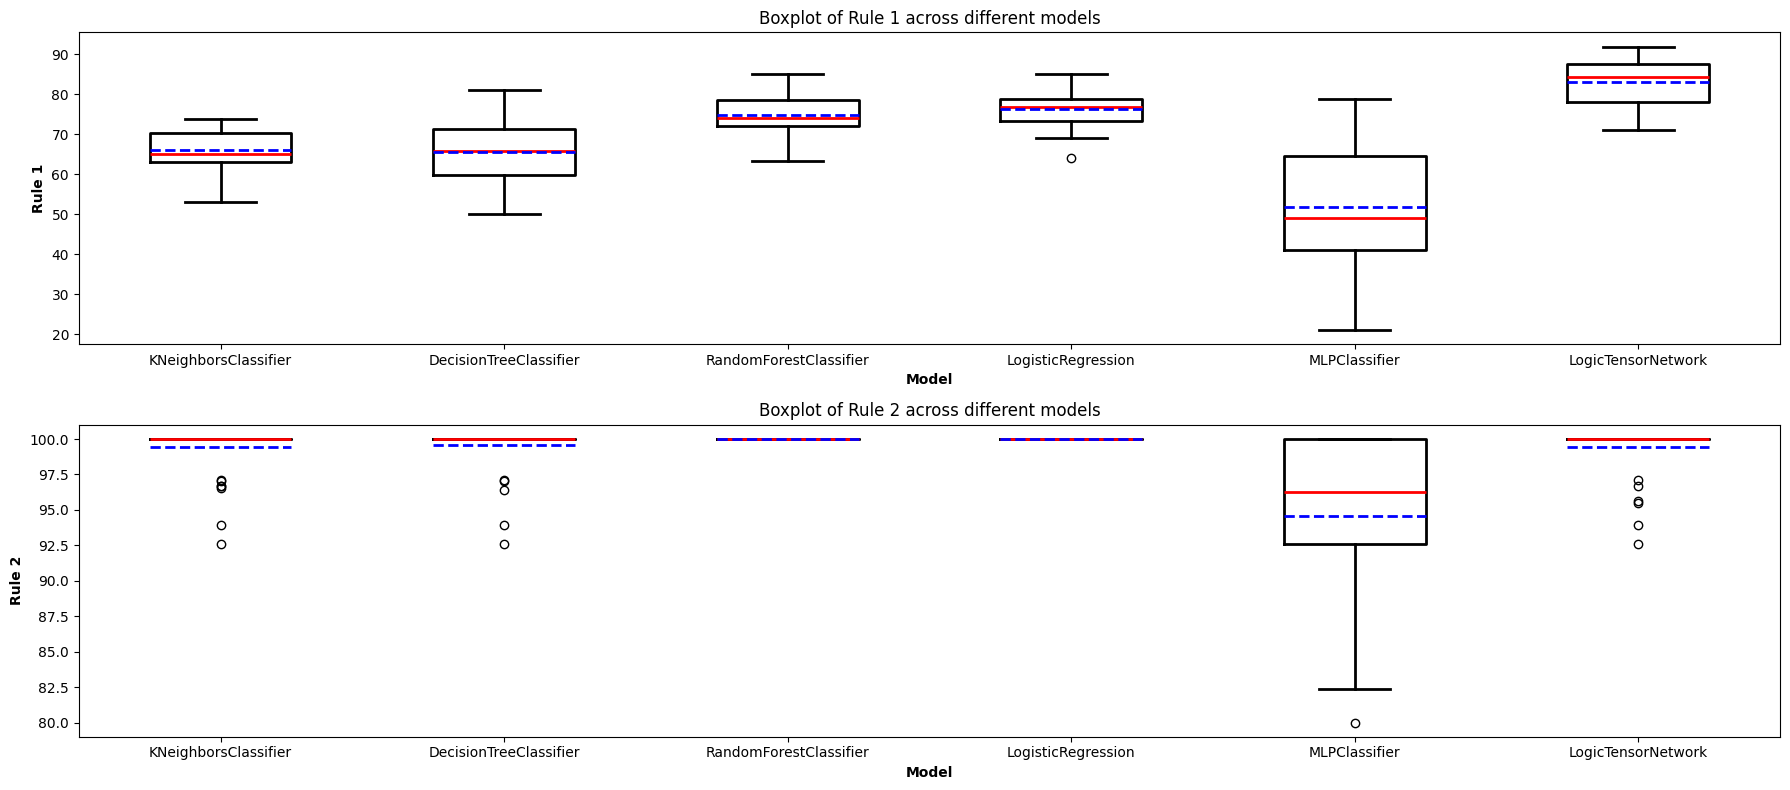

In [33]:
plot_metrics( adherence_df, ["Rule " + str(i) for i in range(1, 3)])

In [34]:
compare_models(adherence_df)


Rule 1:
  LogicTensorNetwork is significantly better than KNeighborsClassifier (p = 0.0000)
  LogicTensorNetwork is significantly better than DecisionTreeClassifier (p = 0.0000)
  LogicTensorNetwork is significantly better than RandomForestClassifier (p = 0.0000)
  LogicTensorNetwork is significantly better than LogisticRegression (p = 0.0000)
  LogicTensorNetwork is significantly better than MLPClassifier (p = 0.0000)

Rule 2:
  RandomForestClassifier is significantly better than KNeighborsClassifier (p = 0.0123)
  RandomForestClassifier is significantly better than DecisionTreeClassifier (p = 0.0367)
  RandomForestClassifier is NOT significantly better than LogisticRegression (p = nan)
  RandomForestClassifier is significantly better than MLPClassifier (p = 0.0000)
  RandomForestClassifier is significantly better than LogicTensorNetwork (p = 0.0183)


In [35]:
for model in metrics_df.index:
    perform_t_tests(adherence_df, model)
    print()
    print( "-" * 100)


Rule 1:
  LogicTensorNetwork is significantly better than KNeighborsClassifier (p = 0.0000)

Rule 2:
  There is no significant difference between LogicTensorNetwork and KNeighborsClassifier (p = 0.9304)

----------------------------------------------------------------------------------------------------

Rule 1:
  LogicTensorNetwork is significantly better than DecisionTreeClassifier (p = 0.0000)

Rule 2:
  There is no significant difference between LogicTensorNetwork and DecisionTreeClassifier (p = 0.7326)

----------------------------------------------------------------------------------------------------

Rule 1:
  LogicTensorNetwork is significantly better than RandomForestClassifier (p = 0.0000)

Rule 2:
  RandomForestClassifier is significantly better than LogicTensorNetwork (p = 0.0183)

----------------------------------------------------------------------------------------------------

Rule 1:
  LogicTensorNetwork is significantly better than LogisticRegression (p = 0.0000)

